In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/天然气TTF连1价格Non-Trend_F0.1.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['天然气TTF连1价格Non-Trend/F0.1'].last_valid_index()

sheet.columns  

Index(['天然气TTF连1价格Non-Trend/F0.1', '欧盟天然气消耗量超季节性/3年/7DMA', 'WTI连1-连4月差',
       '德国10年期国债收益率', '欧洲天然气库容比拟合残差/西北欧平均温度/30DMA', 'WTI原油期货价格',
       '欧盟天然气供给量/30DMA超季节性/3年', '欧盟天然气供需差/30DMA超季节性/3年', '欧洲四国电力负荷合计超季节性/5年',
       '欧元区经济惊喜指数', 'VIX指数/20DMA', 'GPR地缘风险指数/20DMA'],
      dtype='object')

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


################################# 处理缺失值 #################################
fill_methods = {
    '欧盟天然气消耗量超季节性/3年/7DMA': 'interpolate', 
    'WTI连1-连4月差': 'interpolate',
    '德国10年期国债收益率': 'interpolate', 
    '欧洲天然气库容比拟合残差/西北欧平均温度/30DMA': 'interpolate', 
    'WTI原油期货价格': 'interpolate',
    '欧盟天然气供给量/30DMA超季节性/3年':'interpolate', 
    '欧盟天然气供需差/30DMA超季节性/3年' :'interpolate',
    '欧元区经济惊喜指数':'interpolate', 
    '欧洲四国电力负荷合计超季节性/5年':'interpolate',
    'VIX指数/20DMA':'interpolate',
    'GPR地缘风险指数/20DMA':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
# sheet.loc[:last_day, '天然气TTF连1价格Non-Trend/F0.1'] = sheet.loc[:last_day, '天然气TTF连1价格Non-Trend/F0.1'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['德国10年期国债收益率_提前20天'] = sheet['德国10年期国债收益率'].shift(28)
sheet['欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天'] = sheet['欧洲天然气库容比拟合残差/西北欧平均温度/30DMA'].shift(42)
sheet['WTI原油期货价格_提前35天'] = sheet['WTI原油期货价格'].shift(42)
sheet['欧盟天然气消耗量超季节性/3年/7DMA_提前22天'] = sheet['欧盟天然气消耗量超季节性/3年/7DMA'].shift(30)
sheet['WTI连1-连4月差_提前20天'] = sheet['WTI连1-连4月差'].shift(28)
sheet['欧盟天然气供给量/30DMA超季节性/3年_提前20天'] = sheet['欧盟天然气供给量/30DMA超季节性/3年'].shift(31)
sheet['欧盟天然气供需差/30DMA超季节性/3年_提前20天'] = sheet['欧盟天然气供需差/30DMA超季节性/3年'].shift(30)
sheet['欧洲四国电力负荷合计超季节性/5年_提前70天'] = sheet['欧洲四国电力负荷合计超季节性/5年'].shift(93)
sheet['欧元区经济惊喜指数_提前115天'] = sheet['欧元区经济惊喜指数'].shift(127)
sheet['VIX指数/20DMA_提前48天'] = sheet['VIX指数/20DMA'].shift(55)
sheet['GPR地缘风险指数/20DMA_提前57天'] = sheet['GPR地缘风险指数/20DMA'].shift(57)

sheet['欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天_逆序'] = reverse_column(sheet, '欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天')
sheet['欧盟天然气供给量/30DMA超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '欧盟天然气供给量/30DMA超季节性/3年_提前20天')
sheet['欧盟天然气供需差/30DMA超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '欧盟天然气供需差/30DMA超季节性/3年_提前20天')
sheet['VIX指数/20DMA_提前48天_逆序'] = reverse_column(sheet, 'VIX指数/20DMA_提前48天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['天然气TTF连1价格Non-Trend/F0.1'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [5]:
sheet_daily.tail()

,Date,天然气TTF连1价格Non-Trend/F0.1,欧盟天然气消耗量超季节性/3年/7DMA,WTI连1-连4月差,德国10年期国债收益率,欧洲天然气库容比拟合残差/西北欧平均温度/30DMA,WTI原油期货价格,欧盟天然气供给量/30DMA超季节性/3年,欧盟天然气供需差/30DMA超季节性/3年,欧元区经济惊喜指数,...,欧盟天然气供给量/30DMA超季节性/3年_提前20天,欧盟天然气供需差/30DMA超季节性/3年_提前20天,欧洲四国电力负荷合计超季节性/5年_提前70天,欧元区经济惊喜指数_提前115天,VIX指数/20DMA_提前48天,GPR地缘风险指数/20DMA_提前57天,欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天_逆序,欧盟天然气供给量/30DMA超季节性/3年_提前20天_逆序,欧盟天然气供需差/30DMA超季节性/3年_提前20天_逆序,VIX指数/20DMA_提前48天_逆序
1047,2025-11-19,NaN,238.1524,0.9,2.68,-15.9349,61.55,-179.2626,-0.4973,7.1,...,79.3751,-0.1157,-5192.3234,32.200000,15.403000,138.1015,-16.3186,-571.5339,0.8255,59.408500
1048,2025-11-20,NaN,238.1524,0.9,2.68,-15.9349,61.55,-179.2626,-0.4973,7.1,...,13.7510,-0.2069,-4807.6254,31.500000,15.424833,134.0850,-16.4183,-505.9098,0.9167,59.386667
1049,2025-11-21,NaN,238.1524,0.9,2.68,-15.9349,61.55,-179.2626,-0.4973,7.1,...,-39.1050,-0.2717,-4478.7573,31.600000,15.446667,134.6190,-16.4986,-453.0538,0.9815,59.364833
1050,2025-11-24,NaN,238.1524,0.9,2.68,-15.9349,61.55,-179.2626,-0.4973,7.1,...,-66.3211,-0.3014,-4559.6327,31.766667,15.468500,138.1210,-16.4196,-425.8377,1.0112,59.343000
1051,2025-11-25,NaN,238.1524,0.9,2.68,-15.9349,61.55,-179.2626,-0.4973,7.1,...,-77.8817,-0.3175,-5106.9074,31.933333,15.569500,137.6190,-16.1113,-414.2771,1.0273,59.242000


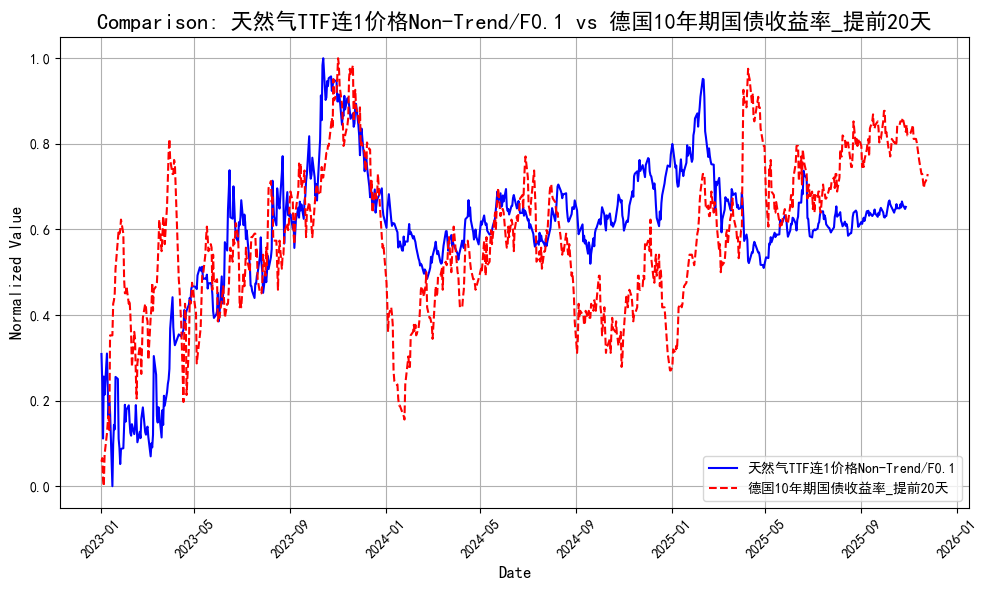

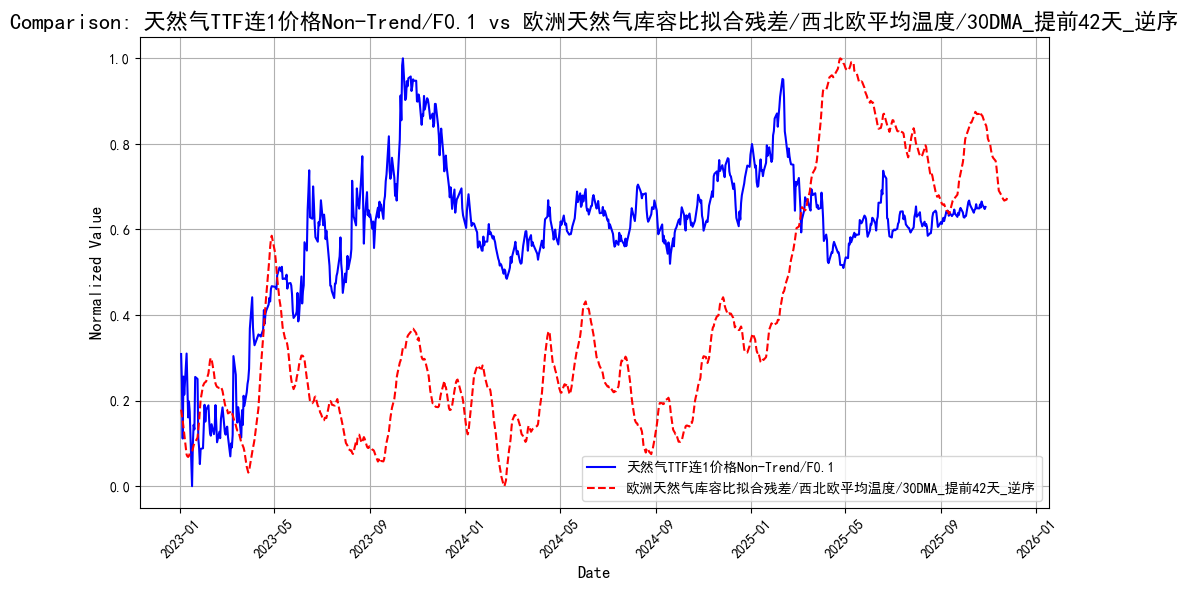

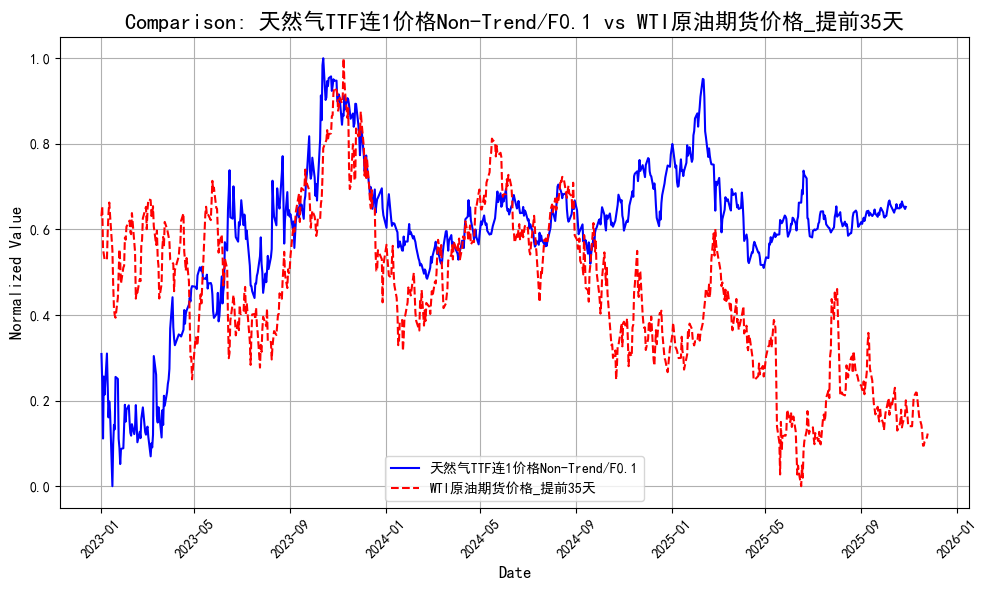

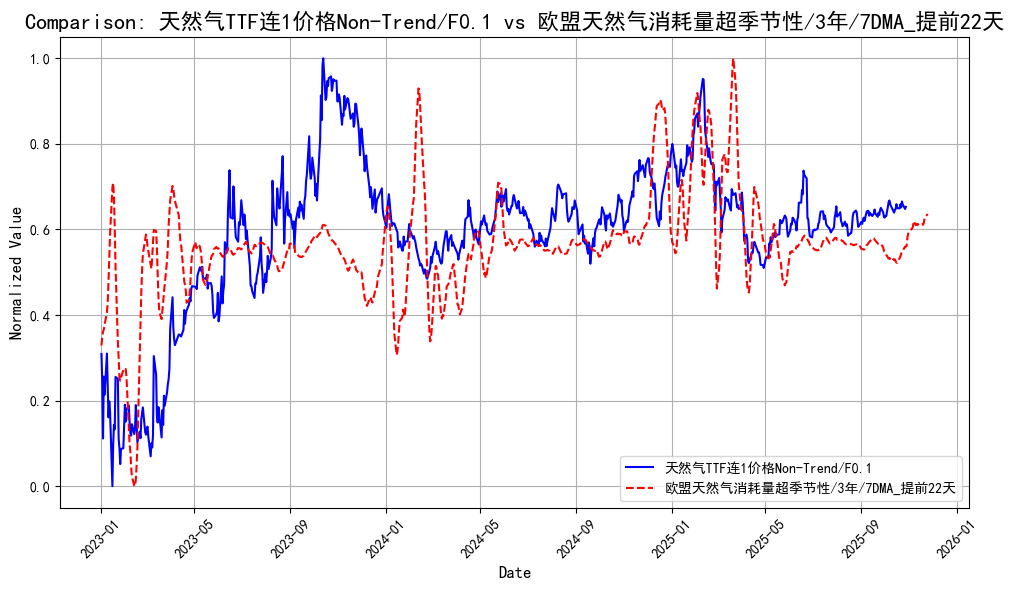

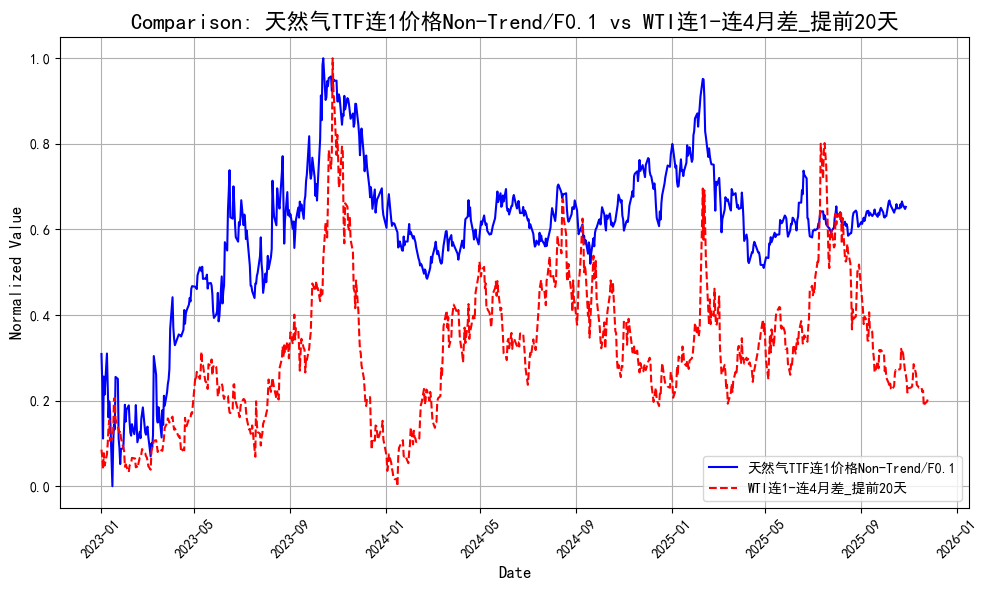

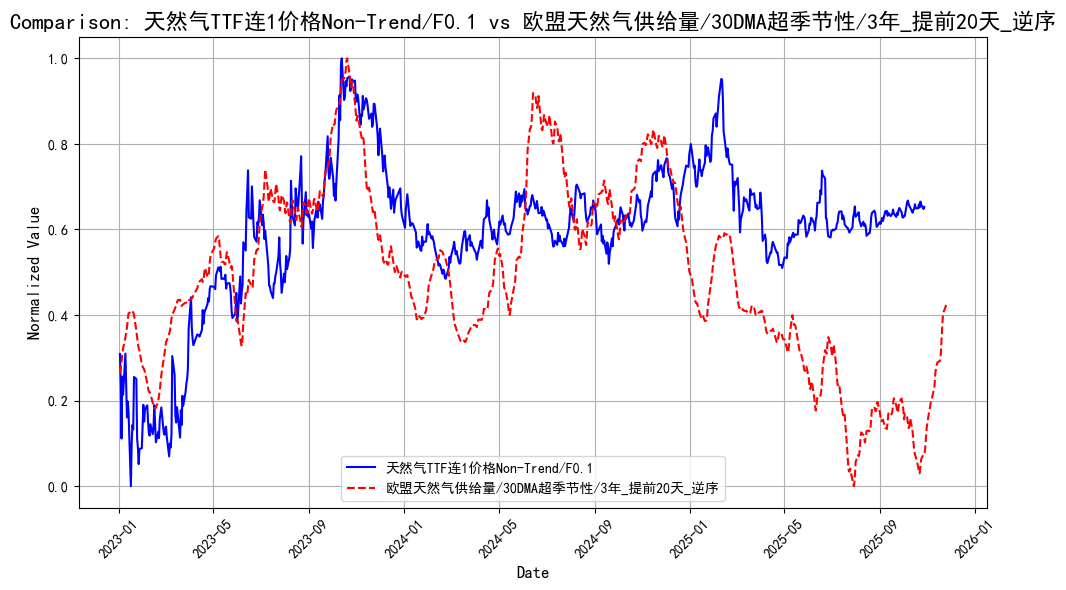

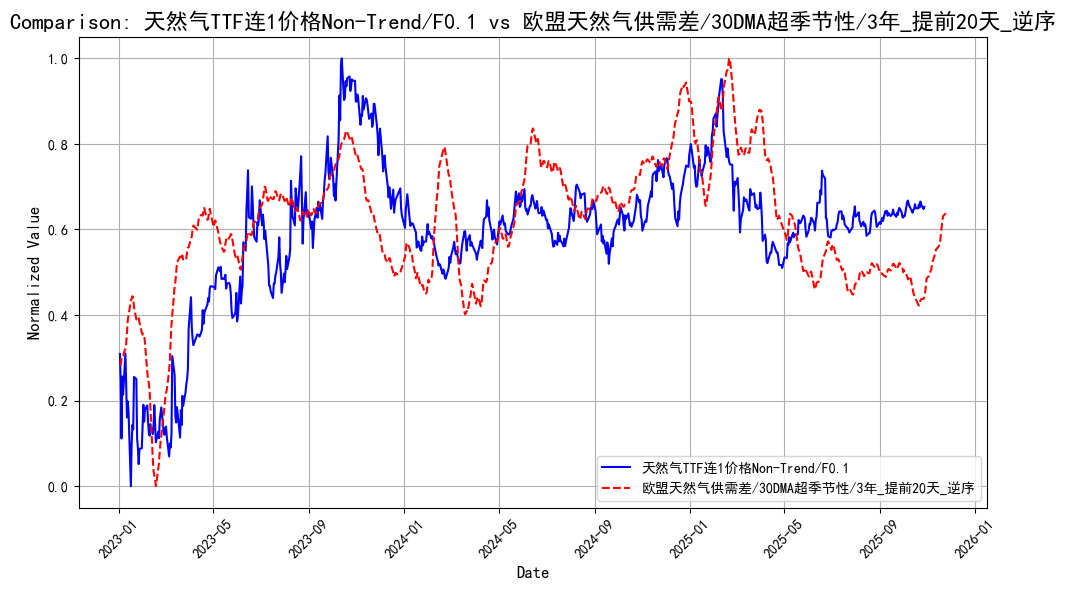

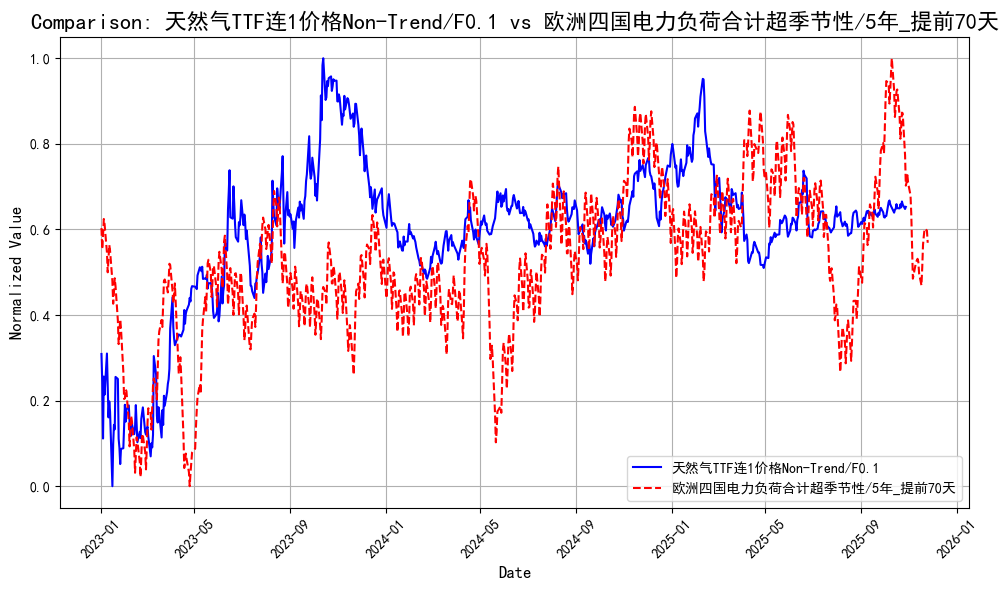

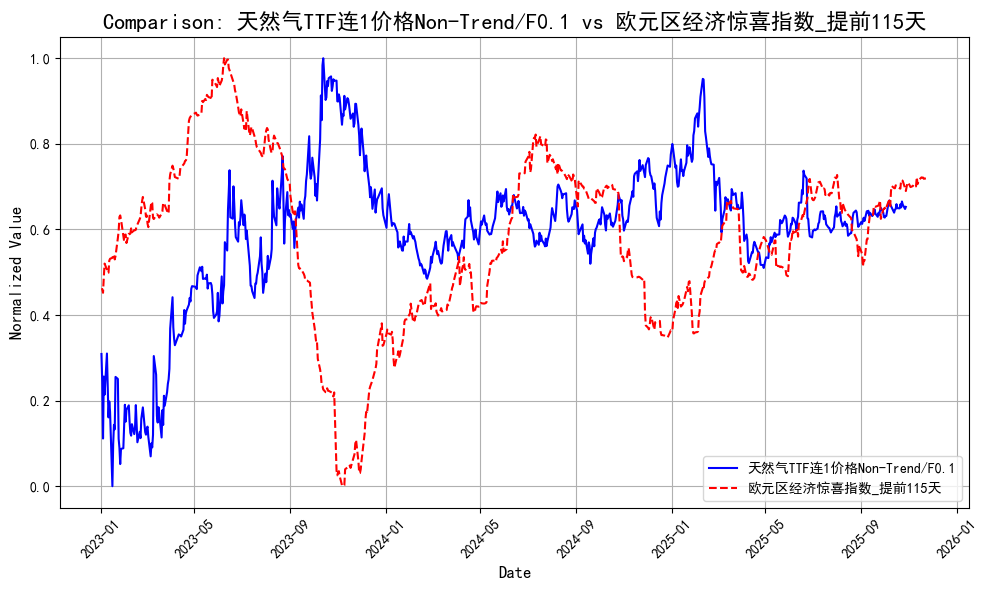

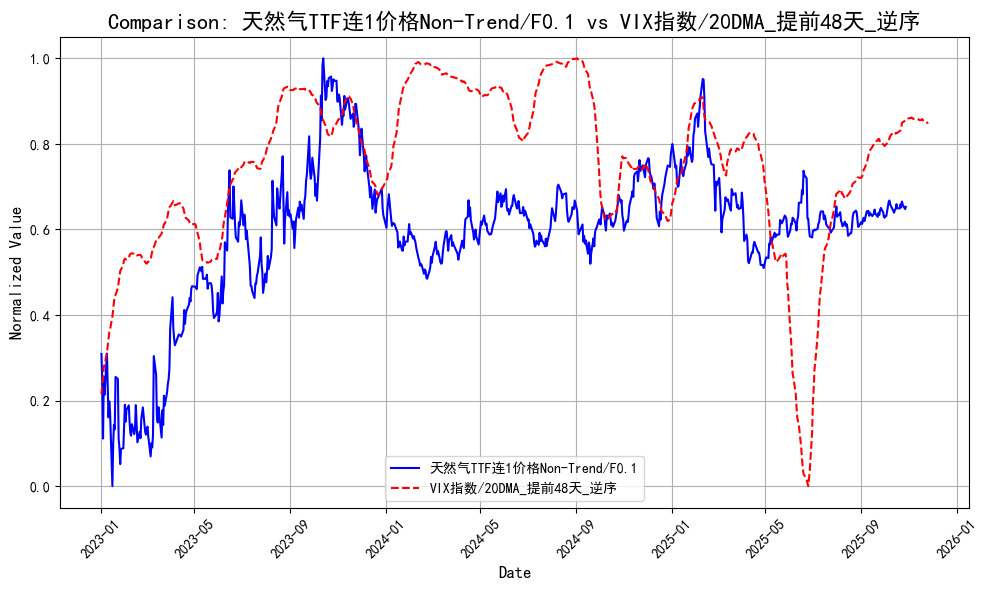

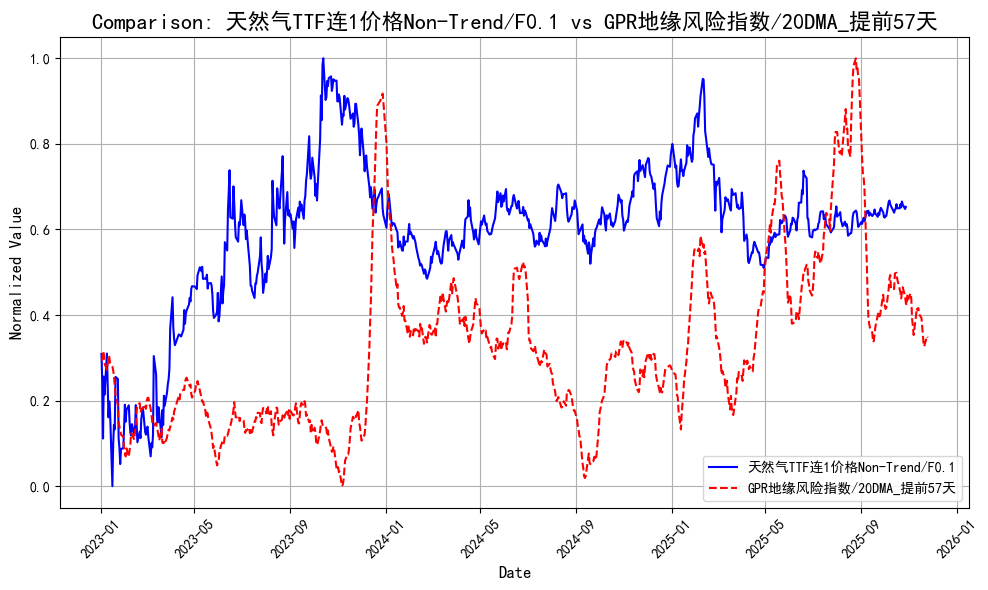

In [6]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='天然气TTF连1价格Non-Trend/F0.1', 
    compare_cols=[
        '德国10年期国债收益率_提前20天',
        '欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天_逆序',
        'WTI原油期货价格_提前35天',
        '欧盟天然气消耗量超季节性/3年/7DMA_提前22天',
        'WTI连1-连4月差_提前20天',
        '欧盟天然气供给量/30DMA超季节性/3年_提前20天_逆序',
        '欧盟天然气供需差/30DMA超季节性/3年_提前20天_逆序',
        '欧洲四国电力负荷合计超季节性/5年_提前70天',
        '欧元区经济惊喜指数_提前115天',
        'VIX指数/20DMA_提前48天_逆序',
        'GPR地缘风险指数/20DMA_提前57天'
       ]
)

In [7]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 21
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '德国10年期国债收益率_提前20天',
#        '欧洲天然气库容比拟合残差/西北欧平均温度/30DMA_提前42天_逆序',
        'WTI原油期货价格_提前35天',
        '欧盟天然气消耗量超季节性/3年/7DMA_提前22天',
        'WTI连1-连4月差_提前20天',
        '欧盟天然气供给量/30DMA超季节性/3年_提前20天_逆序',
        '欧盟天然气供需差/30DMA超季节性/3年_提前20天_逆序',
        '欧洲四国电力负荷合计超季节性/5年_提前70天',
        '欧元区经济惊喜指数_提前115天',
        'VIX指数/20DMA_提前48天_逆序',
        'GPR地缘风险指数/20DMA_提前57天'
        
]

predict_column = '天然气TTF连1价格Non-Trend/F0.1'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.401, 
    'max_depth': 7, 
    'min_child_weight': 7, 
    'subsample': 0.75, 
    'colsample_bytree': 0.6, 
    'gamma': 0.5, 
    'reg_alpha': 0.5, 
    'reg_lambda': 2,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}



num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:2.43344	train-rmse:5.98342


[100]	eval-rmse:3.12228	train-rmse:0.44226


[200]	eval-rmse:3.07828	train-rmse:0.41206


[300]	eval-rmse:2.98983	train-rmse:0.40113


[400]	eval-rmse:3.02909	train-rmse:0.39603


[499]	eval-rmse:2.98168	train-rmse:0.39382


训练集 MSE (DMatrix): 0.1644, 训练集 R² (DMatrix): 0.9981
测试集 MSE (DMatrix): 8.8904, 测试集 R² (DMatrix): -22.2527


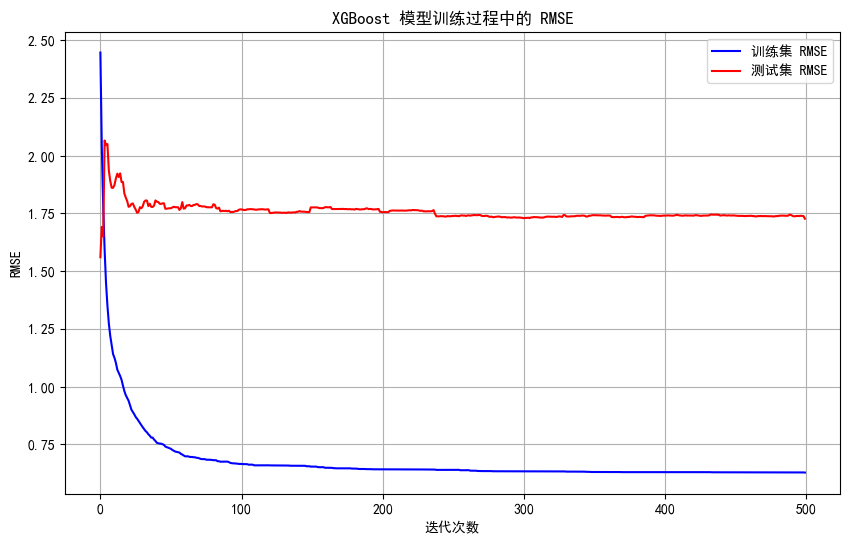

In [8]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:5.93460


[100]	train-rmse:0.44754


[200]	train-rmse:0.40984


[300]	train-rmse:0.39149


[400]	train-rmse:0.38623


[499]	train-rmse:0.38029


全部数据 MSE: 0.1505, 全部数据 R²: 0.9982


Gap between last actual value and first prediction: 0.07561865940094004


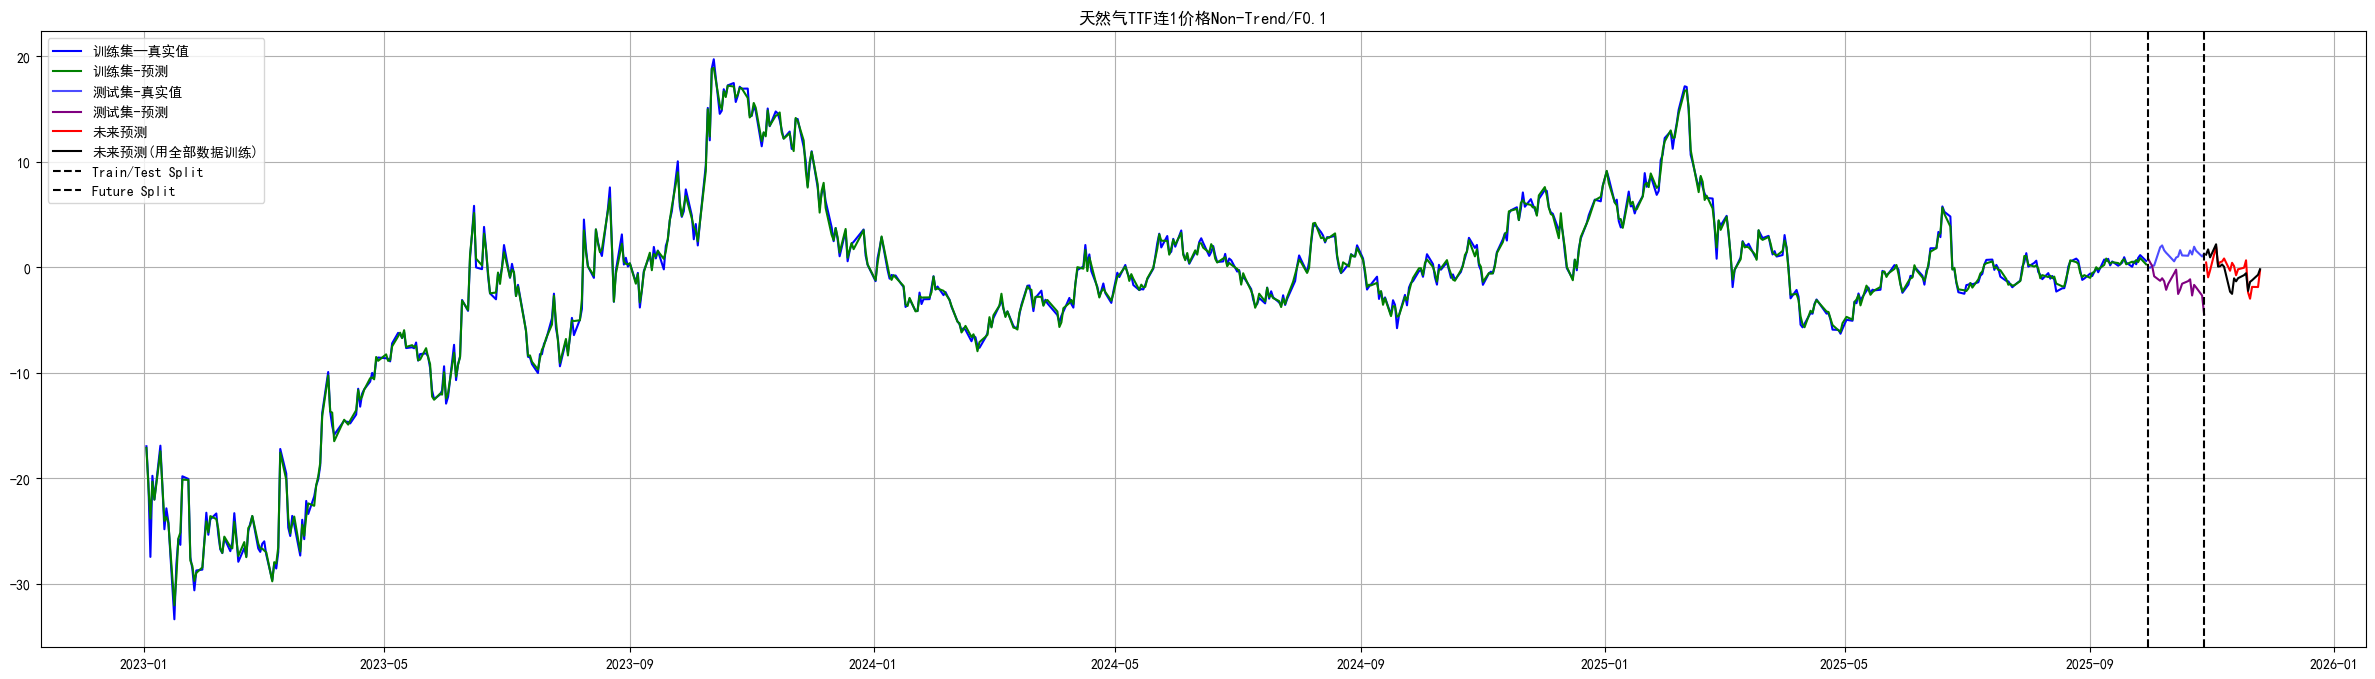

In [10]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('天然气TTF连1价格Non-Trend/F0.1')
plt.legend()
plt.grid(True)
plt.show()


---

In [11]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/天然气TTF连1价格Non-Trend—F0.2_合并数据.xlsx', index=False,float_format='%.4f')

merged_df_daily

,Date,真实值,预测值
741,2025/11/25,NaN,-0.179377
740,2025/11/24,NaN,-0.705749
739,2025/11/21,NaN,-1.229405
738,2025/11/20,NaN,-1.377288
737,2025/11/19,NaN,-2.231446
...,...,...,...
4,2023/01/06,-22.0066,NaN
3,2023/01/05,-19.7628,NaN
2,2023/01/04,-27.4517,NaN
1,2023/01/03,-20.4430,NaN


In [12]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/天然气TTF连1价格Non-Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-0.739620
33,2025/10/31,1.172105,-1.153849
32,2025/09/30,0.290391,0.307985
31,2025/08/31,-0.610500,-0.576366
30,2025/07/31,-0.685487,-0.713333
29,2025/06/30,0.608971,0.582575
28,2025/05/31,-1.970281,-1.993737
27,2025/04/30,-3.619815,-3.552092
26,2025/03/31,1.813729,1.807161
25,2025/02/28,9.585280,9.597822


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "天然气TTF连1价格Non-Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "详情页"
identifier = "天然气TTF连1价格Non-Trend/F0.1"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
